# 2D Denoising Score Matching 實驗

##  實驗資料
常見的 2D 資料集：
- 雙峰高斯（GMM-2）：$x \sim \tfrac{1}{2}\mathcal{N}(\mu_1,\Sigma_1) + \tfrac{1}{2}\mathcal{N}(\mu_2,\Sigma_2)$  
- 兩圈同心圓（Two Circles）  
- 月牙形（Two Moons）  

---

## 實驗步驟
1. **Sample**：取一批 $x \in \mathbb{R}^2$  
2. **加噪**：$\tilde{x} = x + \sigma \epsilon,\ \epsilon \sim \mathcal{N}(0,I)$  
3. **模型**：$s_\theta(\tilde{x}, \sigma)$，輸入 $2$ 維 + 噪聲嵌入，輸出 $2$ 維向量  
4. **Training**：最小化 DSM loss  
5. **Visualization A**：在網格上畫出 $s_\theta(z,\sigma)$ 的向量場  
6. **Visualization B**：比較 $x$、$\tilde{x}$、與 $x^{(1)} = \tilde{x} + \eta s_\theta(\tilde{x},\sigma)$  
7. **Generation**：從純噪音逐步反推樣本分布  

---

## DSM Loss（單一噪聲）
給定 $x \sim p_{\text{data}}$、$\tilde{x} \sim \mathcal{N}(x, \sigma^2 I)$，  
模型應逼近：
$$
s_\theta(\tilde{x}, \sigma) \approx \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x) = -\frac{\tilde{x}-x}{\sigma^2}
$$

對應的loss function：
$$
\mathcal{L}_{\text{DSM}}(\theta) =
\mathbb{E}_{x,\tilde{x}}
\left[
\tfrac{1}{2}
\left\|
s_\theta(\tilde{x},\sigma)
+ \frac{\tilde{x}-x}{\sigma^2}
\right\|^2
\right]
$$

---

## DSM Loss（多噪聲版本）
若噪聲層級為 $\sigma_t$，則：
$$
\mathcal{L}_{\text{DSM}}(\theta) =
\mathbb{E}_{t,x,\epsilon}
\left[
\tfrac{1}{2} w(t)
\left\|
s_\theta(x + \sigma_t \epsilon, t)
+ \frac{\epsilon}{\sigma_t}
\right\|^2
\right]
$$
其中 $w(t)$ 可取 $1$、$\sigma_t^2$、或 $1/\sigma_t^2$。

---

## 實驗設定
- 資料量：每步 mini-batch $128 \sim 512$  
- 噪聲：單層 $\sigma \in [0.1, 0.2]$；或多層 $\sigma_t \in [1.0, 0.01]$  
- 模型：MLP（hidden $128 \sim 256$，SiLU/Swish，$2 \sim 4$ 層）  
- 學習率：$1\text{e-}3$  
- 評估：向量場、去噪前後散點圖、或生成分布對照  

---

## 重點
- DSM 學習訊號為：$-\frac{\tilde{x}-x}{\sigma^2}$ 或 $-\frac{\epsilon}{\sigma}$  
- 多尺度 DSM 是 diffusion model 的理論基礎  


In [16]:
# ============================
# 2D DSM with Train/Val/Test + Loss Curves + Score Field (Notebook-friendly)
# ============================
import math, random, os
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles


# -----------------------
# Reproducibility & device
# -----------------------
def set_seed(seed=0):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

DEVICE = torch.device("cpu")
set_seed(0)

# ---------------
# Data Generators
# ---------------
def sample_gmm2(n=4096, means=None, covs=None, p=0.5, device=DEVICE):
    if means is None:
        means = [np.array([0.0, 0.0]), np.array([3.0, 3.0])]
    if covs is None:
        covs = [np.array([[1.0, 0.3],[0.3, 1.2]]),
                np.array([[0.6,-0.2],[-0.2, 0.8]])]
    z = np.random.rand(n) < p
    n1 = int(z.sum()); n2 = n - n1
    x1 = np.random.multivariate_normal(means[0], covs[0], size=n1)
    x2 = np.random.multivariate_normal(means[1], covs[1], size=n2)
    X  = np.concatenate([x1, x2], axis=0).astype(np.float32)
    np.random.shuffle(X)
    return torch.tensor(X, device=device)

def sample_two_moons(n=4096, noise=0.06, device=DEVICE):
    X, _ = make_moons(n_samples=n, noise=noise)
    return torch.tensor(X, dtype=torch.float32, device=device)

def sample_two_circles(n=4096, noise=0.06, factor=0.5, device=DEVICE):
    X, _ = make_circles(n_samples=n, noise=noise, factor=factor)
    return torch.tensor(X, dtype=torch.float32, device=device)

def get_dataset(name="gmm2", n=12000, device=DEVICE):
    name = name.lower()
    if name == "gmm2":   X = sample_gmm2(n=n, device=device)
    elif name == "moons":   X = sample_two_moons(n=n, device=device)
    elif name == "circles": X = sample_two_circles(n=n, device=device)
    else: raise ValueError("unknown dataset")
    return X



In [17]:
# -----------------
# Split helper
# -----------------
def split_tensor(X, ratios=(0.8, 0.1, 0.1)):
    n = X.shape[0]
    idx = torch.randperm(n, device=X.device)
    n_tr = int(n*ratios[0]); n_va = int(n*ratios[1]); n_te = n - n_tr - n_va
    i_tr = idx[:n_tr]; i_va = idx[n_tr:n_tr+n_va]; i_te = idx[n_tr+n_va:]
    return X[i_tr], X[i_va], X[i_te]

# -----------------
# Noise schedule
# -----------------
def geometric_sigma_schedule(T=8, sigma_min=0.02, sigma_max=0.8, device=DEVICE):
    sigmas = np.geomspace(sigma_max, sigma_min, T).astype(np.float32)
    return torch.tensor(sigmas, device=device)

# -----------------------
# Time / Noise Embedding
# -----------------------
class FourierTimeEmbedding(nn.Module):
    def __init__(self, dim=64, max_freq=10.0):
        super().__init__()
        self.dim = dim; self.max_freq = max_freq
    def forward(self, s):  # s: (B,)
        s = s.view(-1,1)
        k = torch.linspace(1.0, self.max_freq, self.dim, device=s.device).view(1,-1)
        a = s * k
        return torch.cat([torch.sin(a), torch.cos(a)], dim=-1)



In [18]:
# -------
# Model
# -------
class ScoreMLP(nn.Module):
    def __init__(self, hidden=256, time_dim=64, num_layers=3):
        super().__init__()
        self.t_emb = FourierTimeEmbedding(dim=time_dim)
        in_dim = 2 + 2*time_dim
        layers = [nn.Linear(in_dim, hidden), nn.SiLU()]
        for _ in range(num_layers-1):
            layers += [nn.Linear(hidden, hidden), nn.SiLU()]
        layers += [nn.Linear(hidden, 2)]
        self.net = nn.Sequential(*layers)
    def forward(self, x, log_sigma):
        te = self.t_emb(log_sigma)
        return self.net(torch.cat([x, te], dim=-1))

# -------------
# DSM Loss
# -------------
def dsm_loss_multi_sigma(model, x, sigmas, w_mode="none"):
    B = x.shape[0]; T = len(sigmas)
    t_idx = torch.randint(0, T, (B,), device=x.device)
    sigma_t = sigmas[t_idx]               # (B,)
    eps = torch.randn_like(x)
    x_tilde = x + sigma_t.view(-1,1) * eps
    target = - eps / sigma_t.view(-1,1)   # -(x~-x)/sigma^2

    if   w_mode=="none":       w = torch.ones(B, device=x.device)
    elif w_mode=="sigma2":     w = sigma_t**2
    elif w_mode=="inv_sigma2": w = 1.0/(sigma_t**2 + 1e-12)
    else: raise ValueError

    log_sigma = torch.log(sigma_t + 1e-12)
    score_hat = model(x_tilde, log_sigma)             # (B,2)
    loss = 0.5 * ((score_hat - target)**2).sum(dim=-1)
    return (w * loss).mean()

@torch.no_grad()
def eval_dsm_loss(model, X, sigmas, batches=10, bs=512, w_mode="none"):
    """估算在整個資料 X 上的 DSM 損失（抽樣多個mini-batches 取均值）。"""
    n = X.shape[0]; tot = 0.0; cnt = 0
    for _ in range(batches):
        idx = torch.randint(0, n, (bs,), device=X.device)
        loss = dsm_loss_multi_sigma(model, X[idx], sigmas, w_mode=w_mode).item()
        tot += loss; cnt += 1
    return tot / max(cnt,1)

# -------------------------
# Simple EMA
# -------------------------
class WeightEMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {k: v.clone().detach() for k,v in model.state_dict().items()}
    @torch.no_grad()
    def update(self, model):
        for k,v in model.state_dict().items():
            self.shadow[k].mul_(self.decay).add_(v, alpha=1.0-self.decay)
    @torch.no_grad()
    def copy_to(self, model):
        model.load_state_dict(self.shadow, strict=True)



In [19]:
# ----------------
# Visualization
# ----------------
@torch.no_grad()
def plot_vector_field(model, sigma, xlim=(-3,6), ylim=(-3,6), N=25):
    xs = torch.linspace(xlim[0], xlim[1], N, device=DEVICE)
    ys = torch.linspace(ylim[0], ylim[1], N, device=DEVICE)
    Xg, Yg = torch.meshgrid(xs, ys, indexing="xy")
    grid = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=-1)
    log_sigma = torch.full((grid.shape[0],), math.log(sigma), device=DEVICE)
    V = model(grid, log_sigma).cpu().numpy()
    G = grid.cpu().numpy()
    plt.figure(figsize=(6,5))
    plt.quiver(G[:,0], G[:,1], V[:,0], V[:,1], angles="xy", scale_units="xy", scale=30)
    plt.title(f"Score Field (sigma={sigma:.3g})"); plt.xlabel("x1"); plt.ylabel("x2")
    plt.tight_layout(); plt.show()

@torch.no_grad()
def plot_one_step_denoise(model, X, sigma=0.1, eta=0.15, n_show=2000):
    n = min(n_show, X.shape[0]); idx = torch.randperm(X.shape[0], device=X.device)[:n]
    x = X[idx]; eps = torch.randn_like(x)
    x_tilde = x + sigma*eps
    log_sigma = torch.full((n,), math.log(sigma), device=X.device)
    s = model(x_tilde, log_sigma)
    x1 = x_tilde + eta*s
    plt.figure(figsize=(6,5))
    plt.scatter(x[:,0].cpu(), x[:,1].cpu(), s=8, alpha=0.6, label="clean x")
    plt.scatter(x_tilde[:,0].cpu(), x_tilde[:,1].cpu(), s=8, alpha=0.6, label="noisy x~")
    plt.scatter(x1[:,0].cpu(), x1[:,1].cpu(), s=8, alpha=0.6, label="denoised x^(1)")
    plt.legend(); plt.title(f"One-step Denoising (sigma={sigma}, eta={eta})")
    plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout(); plt.show()

# -----------
# Training
# -----------
def moving_avg(x, k=200):
    if k <= 1: return np.asarray(x, float)
    x = np.asarray(x, float)
    k = min(k, len(x))
    w = np.ones(k)/k
    return np.convolve(x, w, mode="valid")

def train_with_val(model, Xtr, Xva, sigmas, steps=4000, batch_size=256, lr=1e-3,
                   ema_decay=0.999, w_mode="none", log_every=200,
                   use_cosine=True, eta_min=1e-5, warmup_steps=500,
                   val_batch_size=1024):

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    if use_cosine:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            opt, T_max=steps-warmup_steps if steps>warmup_steps else steps, eta_min=eta_min
        )
    ema = WeightEMA(model, decay=ema_decay)

    n_tr, n_va = Xtr.shape[0], Xva.shape[0]
    train_hist, val_hist, lr_hist = [], [], []

    for step in range(1, steps+1):
        # ---- train step
        idx = torch.randint(0, n_tr, (batch_size,), device=Xtr.device)
        xb = Xtr[idx]
        loss = dsm_loss_multi_sigma(model, xb, sigmas, w_mode=w_mode)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        ema.update(model)

        # ---- lr schedule
        if use_cosine:
            if step <= warmup_steps:
                for pg in opt.param_groups:
                    pg["lr"] = lr * step / max(1, warmup_steps)
            else:
                scheduler.step()

        train_hist.append(loss.item())
        lr_hist.append(opt.param_groups[0]["lr"])

        with torch.no_grad():
            j = torch.randint(0, n_va, (val_batch_size,), device=Xva.device)
            vb = Xva[j]
            vloss = dsm_loss_multi_sigma(model, vb, sigmas, w_mode=w_mode).item()
            val_hist.append(vloss)

        if step % log_every == 0:
            print(f"[{step:5d}] train={np.mean(train_hist[-log_every:]):.6f} | "
                  f"val≈{np.mean(val_hist[-log_every:]):.6f} | lr={opt.param_groups[0]['lr']:.2e}")

    ema.copy_to(model)
    return np.array(train_hist), np.array(val_hist), np.array(lr_hist)



[  200] train=1541.113889 | val≈1551.164702 | lr=2.00e-04
[  400] train=1555.739126 | val≈1564.785261 | lr=4.00e-04
[  600] train=1588.550672 | val≈1557.854677 | lr=5.00e-04
[  800] train=1584.281370 | val≈1571.636284 | lr=4.98e-04
[ 1000] train=1554.423267 | val≈1563.893061 | lr=4.95e-04
[ 1200] train=1549.943748 | val≈1566.414106 | lr=4.90e-04
[ 1400] train=1571.740394 | val≈1560.578702 | lr=4.83e-04
[ 1600] train=1546.901951 | val≈1551.308363 | lr=4.74e-04
[ 1800] train=1577.136579 | val≈1569.260103 | lr=4.65e-04
[ 2000] train=1565.670201 | val≈1571.962484 | lr=4.53e-04
[ 2200] train=1570.585505 | val≈1566.705817 | lr=4.40e-04
[ 2400] train=1565.956908 | val≈1558.813638 | lr=4.26e-04
[ 2600] train=1588.801906 | val≈1565.637523 | lr=4.11e-04
[ 2800] train=1549.192773 | val≈1556.891957 | lr=3.95e-04
[ 3000] train=1539.571364 | val≈1575.674843 | lr=3.77e-04
[ 3200] train=1534.178845 | val≈1565.967474 | lr=3.59e-04
[ 3400] train=1543.989893 | val≈1579.271887 | lr=3.40e-04
[ 3600] train=

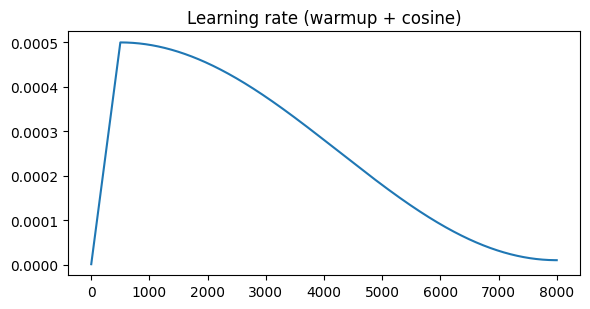

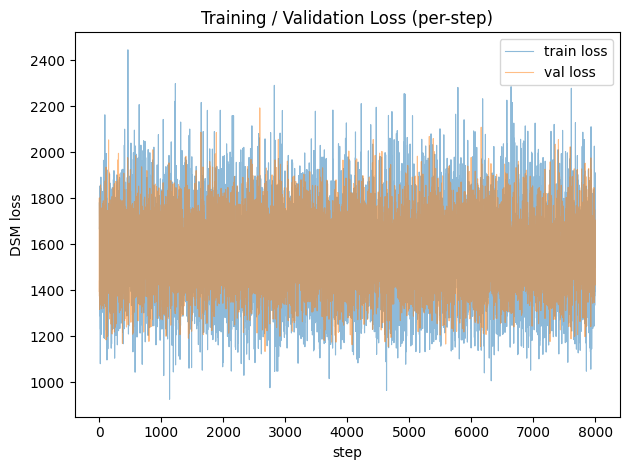

NameError: name 'k' is not defined

<Figure size 640x420 with 0 Axes>

In [20]:
# =========================
# ==== Run the experiment =
# =========================
# Config（可自行調整）
DATASET   = "gmm2"      # "gmm2" / "moons" / "circles"
N_SAMPLES = 12000
SIGMA_MIN, SIGMA_MAX, T = 0.01, 1.0, 10
BATCH, STEPS, LR = 1024, 8000, 5e-4
W_MODE = "none"         # "none" / "sigma2" / "inv_sigma2"
HIDDEN, LAYERS = 256, 3
VIZ_SIGMA, ETA = 0.1, 0.15

# 1) Data & split
X = get_dataset(DATASET, n=N_SAMPLES, device=DEVICE)
Xtr, Xva, Xte = split_tensor(X, ratios=(0.8, 0.1, 0.1))
sigmas = geometric_sigma_schedule(T=T, sigma_min=SIGMA_MIN, sigma_max=SIGMA_MAX, device=DEVICE)

# 2) Model
model = ScoreMLP(hidden=HIDDEN, time_dim=64, num_layers=LAYERS).to(DEVICE)

# 3) Train with validation
train_hist, val_hist, lr_hist = train_with_val(
    model, Xtr, Xva, sigmas,
    steps=8000, batch_size=512, lr=5e-4,
    w_mode="none", log_every=200,
    use_cosine=True, eta_min=1e-5, warmup_steps=500,
    val_batch_size=1024
)

plt.figure(figsize=(6,3.2))
plt.plot(lr_hist); plt.title("Learning rate (warmup + cosine)"); plt.tight_layout(); plt.show()

# 4) Plot losses (train curve + val points)
# 原始曲線
plt.figure(figsize=(6.4,4.8))
plt.plot(train_hist, label="train loss", alpha=0.5, linewidth=0.8, color="tab:blue")
plt.plot(val_hist,   label="val loss",   alpha=0.5, linewidth=0.8, color="tab:orange")
plt.xlabel("step"); plt.ylabel("DSM loss"); plt.title("Training / Validation Loss (per-step)")
plt.legend(); plt.tight_layout(); plt.show()

# 平滑後（移動平均）曲線
K = 200  # 視資料量調整
tr_smooth = moving_avg(train_hist, K)
va_smooth = moving_avg(val_hist,   K)
x = np.arange(len(tr_smooth))
plt.figure(figsize=(6.4,4.2))
plt.plot(x, tr_smooth, label=f"train (MA{k})", color="tab:blue")
plt.plot(x, va_smooth, label=f"val   (MA{k})", color="tab:orange")
plt.xlabel("step"); plt.ylabel("DSM loss"); plt.title("Smoothed Loss (moving average)")
plt.legend(); plt.tight_layout(); plt.show()

# 5) Test loss（使用 EMA 權重）
test_loss = eval_dsm_loss(model, Xte, sigmas, w_mode=W_MODE)
print(f"Test DSM loss = {test_loss:.6f}")

# 6) Score function 可視化（quiver）＋ 一步去噪效果
plot_vector_field(model, sigma=VIZ_SIGMA, xlim=(-3,6), ylim=(-3,6), N=25)
plot_one_step_denoise(model, X, sigma=VIZ_SIGMA, eta=ETA, n_show=2000)


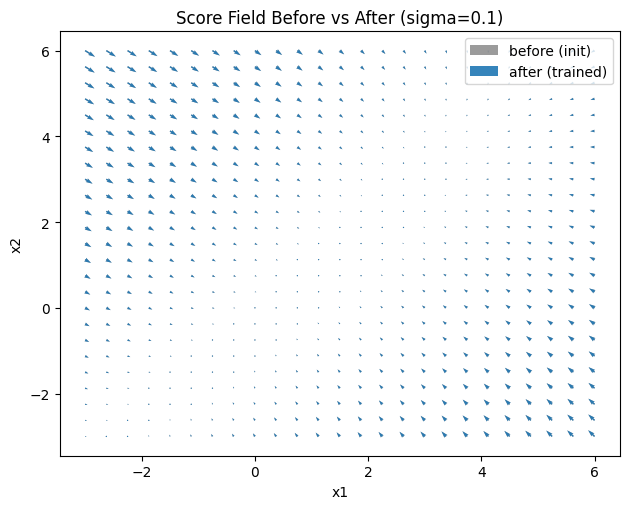

In [21]:
import copy

# 在建立 model 後、訓練前先保存一份
model_init = copy.deepcopy(model).eval()

@torch.no_grad()
def plot_score_before_after(model_before, model_after, sigma, xlim=(-3,6), ylim=(-3,6), N=25):
    xs = torch.linspace(xlim[0], xlim[1], N, device=DEVICE)
    ys = torch.linspace(ylim[0], ylim[1], N, device=DEVICE)
    Xg, Yg = torch.meshgrid(xs, ys, indexing="xy")
    grid = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=-1)
    log_sigma = torch.full((grid.shape[0],), np.log(sigma), device=DEVICE)

    V_before = model_before(grid, log_sigma).cpu().numpy()
    V_after  = model_after(grid,  log_sigma).cpu().numpy()
    G = grid.cpu().numpy()

    plt.figure(figsize=(6.4,5.2))
    # 訓練前：灰黑色、透明一點
    plt.quiver(G[:,0], G[:,1], V_before[:,0], V_before[:,1],
               angles="xy", scale_units="xy", scale=30,
               color="0.35", alpha=0.6, label="before (init)")
    # 訓練後：藍色
    plt.quiver(G[:,0], G[:,1], V_after[:,0],  V_after[:,1],
               angles="xy", scale_units="xy", scale=30,
               color="tab:blue", alpha=0.9, label="after (trained)")
    plt.title(f"Score Field Before vs After (sigma={sigma})")
    plt.xlabel("x1"); plt.ylabel("x2"); plt.legend()
    plt.tight_layout(); plt.show()

# 訓練完成（且已 copy EMA 權重到 model）後呼叫：
plot_score_before_after(model_init, model, sigma=0.1)
